In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="15LBQzC0LFqOPw1sQj5b")
project = rf.workspace("hack-m6ese").project("7-17-u6cxi-fzwqa")
version = project.version(1)
dataset = version.download("yolov8-obb")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 90.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to 7-17-1 in yolov8-obb:: 100%|██████████| 1315/1315 [00:00<00:00, 2588.51it/s]


In [2]:
# Install required libraries
!pip install -U ultralytics opencv-python matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 67.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


In [3]:
#Load Dataset (Roboflow API Output)

import os

DATASET_PATH = "/content/7-17-1"

assert os.path.exists(DATASET_PATH), "Dataset path not found!"

for split in ["train", "valid"]:
    img_dir = os.path.join(DATASET_PATH, split, "images")
    lbl_dir = os.path.join(DATASET_PATH, split, "labels")

    print(f"{split.upper()}:")
    print(f"  Images: {len(os.listdir(img_dir))}")
    print(f"  Labels: {len(os.listdir(lbl_dir))}")

TRAIN:
  Images: 543
  Labels: 543
VALID:
  Images: 110
  Labels: 110


In [4]:
#Inspect & Validate Classes (CRITICAL)

from collections import Counter

def count_classes(path):
    counter = Counter()
    for split in ["train", "valid"]:
        label_dir = os.path.join(path, split, "labels")
        for file in os.listdir(label_dir):
            with open(os.path.join(label_dir, file)) as f:
                for line in f:
                    cls = line.split()[0]
                    counter[cls] += 1
    return counter

class_stats = count_classes(DATASET_PATH)

print("Class distribution:")
for cls_id, count in class_stats.items():
    print(f"Class {cls_id}: {count} instances")


Class distribution:
Class 0: 598 instances
Class 1: 225 instances


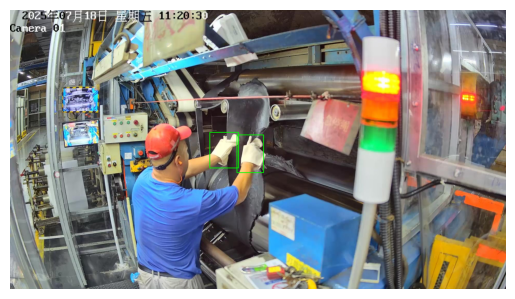

In [5]:
#Visualize Annotations (Quality Check)

import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

img_dir = f"{DATASET_PATH}/train/images"
lbl_dir = f"{DATASET_PATH}/train/labels"

# Get a list of image files
image_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

if not image_files:
    print(f"No image files found in {img_dir}")
else:
    sample = random.choice(image_files)
    img = cv2.imread(os.path.join(img_dir, sample))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img.shape

    label_filename = sample.replace(os.path.splitext(sample)[1], ".txt") # Handle various image extensions
    label_filepath = os.path.join(lbl_dir, label_filename)

    if os.path.exists(label_filepath):
        with open(label_filepath) as f:
            for line in f:
                # Parse 9 values for YOLOv8 OBB format: cls, x1, y1, x2, y2, x3, y3, x4, y4
                values = list(map(float, line.split()))
                if len(values) == 9:
                    cls = int(values[0])
                    # Convert normalized coordinates to pixel coordinates
                    points = np.array(values[1:]).reshape(-1, 2) * np.array([w, h])
                    points = points.astype(int)

                    # Draw the polygon (oriented bounding box)
                    cv2.polylines(img, [points], isClosed=True, color=(0, 255, 0), thickness=2)
                else:
                    print(f"Skipping malformed line in {label_filename}: {line.strip()} (expected 9 values, got {len(values)}) ")
    else:
        print(f"Label file not found for {sample}: {label_filepath}")

    plt.imshow(img)
    plt.axis("off")
    plt.show()


In [6]:
#Dataset Preprocessing

import glob

for lf in glob.glob(f"{DATASET_PATH}/train/labels/*.txt"):
    if os.path.getsize(lf) == 0:
        os.remove(lf)


In [7]:
#Train / Fine-Tune YOLOv8 Model
!yolo task=detect mode=train \
model=yolov8n.pt \
data=/content/7-17-1/data.yaml \
epochs=150 \
imgsz=640 \
batch=32 \
patience=10 \
project=glove_detection \
name=yolov8_glove_model


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/7-17-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

In [9]:
#Save the Model
import shutil

MODEL_SRC = "glove_detection/yolov8_glove_model/weights/best.pt"
MODEL_DST = "/content/best_glove_model.pt"

shutil.copy(MODEL_SRC, MODEL_DST)
print("Model saved successfully")


Model saved successfully


In [10]:
!pip install -U ultralytics opencv-python

In [11]:
%%writefile detect.py
# Inference on New Images using YOLOv8

import os
import json
import cv2
import argparse
from ultralytics import YOLO


def detect(input_dir, output_dir, log_dir, model_path, conf):
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)

    model = YOLO(model_path)

    for img_name in os.listdir(input_dir):
        if not img_name.lower().endswith(".jpg"):
            continue

        img_path = os.path.join(input_dir, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Skipping unreadable image: {img_name}")
            continue

        results = model(img, conf=conf, verbose=False)

        detections = []
        annotated = img.copy()

        for r in results:
            for box in r.boxes:
                cls_id = int(box.cls[0])
                label = model.names[cls_id]
                confidence = float(box.conf[0])
                x1, y1, x2, y2 = map(int, box.xyxy[0])

                detections.append({
                    "label": label,
                    "confidence": round(confidence, 3),
                    "bbox": [x1, y1, x2, y2]
                })

                cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(
                    annotated,
                    f"{label} {confidence:.2f}",
                    (x1, max(y1 - 5, 15)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (0, 255, 0),
                    2
                )

        cv2.imwrite(os.path.join(output_dir, img_name), annotated)

        with open(os.path.join(log_dir, img_name.replace(".jpg", ".json")), "w") as f:
            json.dump({
                "filename": img_name,
                "detections": detections
            }, f, indent=2)

    print("✅ Detection completed successfully")


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--input", required=True)
    parser.add_argument("--output", default="output")
    parser.add_argument("--logs", default="logs")
    parser.add_argument("--model", default="best_glove_model.pt")
    parser.add_argument("--confidence", type=float, default=0.5)
    args = parser.parse_args()

    detect(args.input, args.output, args.logs, args.model, args.confidence)


Writing detect.py


In [15]:
!python detect.py \
--input /content/7-17-1/valid/images\
--output output \
--logs logs \
--model best_glove_model.pt \
--confidence 0.5


✅ Detection completed successfully


In [16]:
!ls
!ls output
!ls logs


7-17-1		     detect.py	      logs    runs	   yolo11n.pt
best_glove_model.pt  glove_detection  output  sample_data  yolov8n.pt
2025071810305065211_jpg.rf.7cf6047d61c870e295aacefcb342008a.jpg
2025071810305125412_jpg.rf.280f227077ab21808d181c74948f7b74.jpg
2025071810305216612_jpg.rf.ee3275e36241bcf2313b9fa5b0e6e1d1.jpg
2025071810305269112_jpg.rf.facde362f5ccc46753f126d1ba2d9907.jpg
2025071810311188111_jpg.rf.80032f8bdd3b95c57cf913e78a980209.jpg
2025071810311205412_jpg.rf.604db4f0a6faf4d1610194e684e2df7d.jpg
2025071810311221011_jpg.rf.4b5eabba36faaaeb0ab94f9b286da2ad.jpg
2025071810311521011_jpg.rf.ebc5bab30649faa9861812844a0ae50a.jpg
2025071810311528911_jpg.rf.4457933e7fd0daa28d7413232a56dfdc.jpg
2025071810311597011_jpg.rf.b87f8701d4274722686211e3359647be.jpg
2025071810311728211_jpg.rf.efa17ac9ba174941f04bb75418d9b968.jpg
2025071810311740411_jpg.rf.7ed3724921a095745d285ab9d8a3370a.jpg
2025071810311908511_jpg.rf.f3cdf8c4f5eb7773ba9c69d78c800b24.jpg
2025071810312709111_jpg.rf.af8e3c2dc37167c

(np.float64(-0.5), np.float64(1919.5), np.float64(1079.5), np.float64(-0.5))

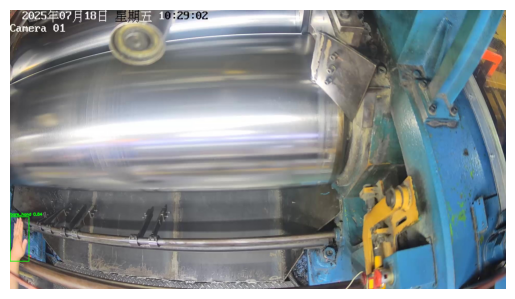

In [27]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/output/2025071810305065211_jpg.rf.7cf6047d61c870e295aacefcb342008a.jpg")
plt.imshow(img)
plt.axis("off")


(np.float64(-0.5), np.float64(1919.5), np.float64(1079.5), np.float64(-0.5))

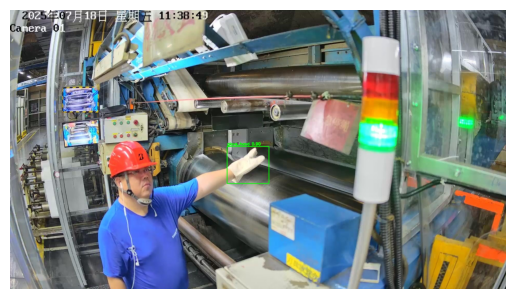

In [29]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/output/2025071811405331112_jpg.rf.92b0491c3a7ab45a2f1a626b1e468c8e.jpg")
plt.imshow(img)
plt.axis("off")


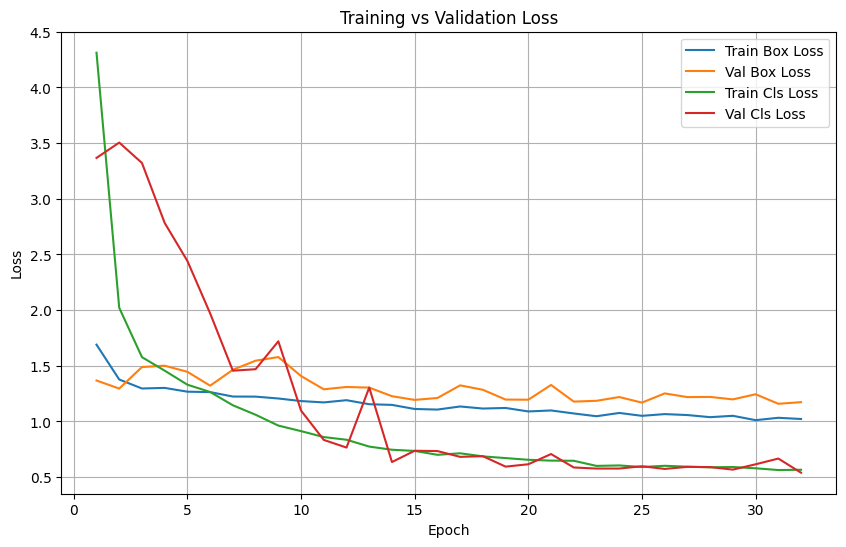

In [19]:
#Plot Training & Validation Metrics
import pandas as pd
import matplotlib.pyplot as plt

results = pd.read_csv(
    "glove_detection/yolov8_glove_model/results.csv"
)

# Plot losses
plt.figure(figsize=(10,6))
plt.plot(results["epoch"], results["train/box_loss"], label="Train Box Loss")
plt.plot(results["epoch"], results["val/box_loss"], label="Val Box Loss")
plt.plot(results["epoch"], results["train/cls_loss"], label="Train Cls Loss")
plt.plot(results["epoch"], results["val/cls_loss"], label="Val Cls Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()


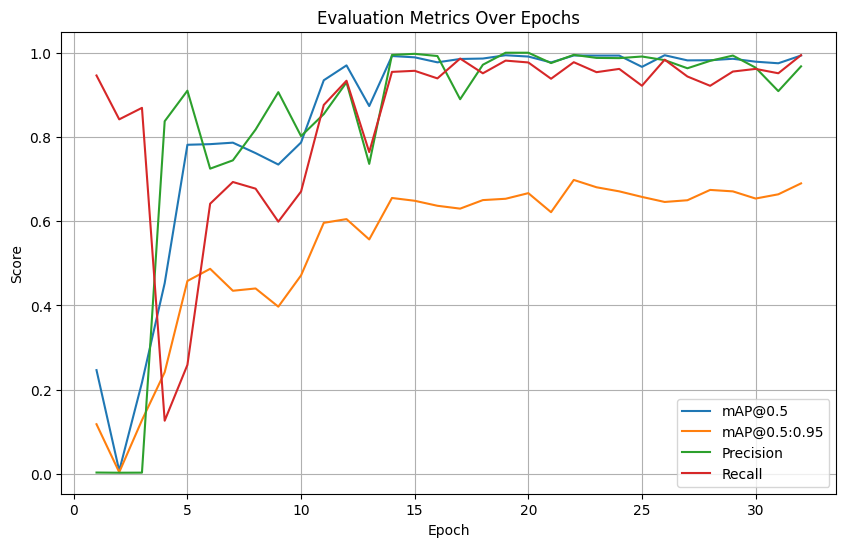

In [21]:
#Plot mAP, Precision & Recall

# Clean column names by stripping whitespace
results.columns = results.columns.str.strip()

plt.figure(figsize=(10,6))
plt.plot(results["epoch"], results["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(results["epoch"], results["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")
plt.plot(results["epoch"], results["metrics/precision(B)"], label="Precision")
plt.plot(results["epoch"], results["metrics/recall(B)"], label="Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Evaluation Metrics Over Epochs")
plt.legend()
plt.grid()
plt.show()

(np.float64(-0.5), np.float64(2999.5), np.float64(2249.5), np.float64(-0.5))

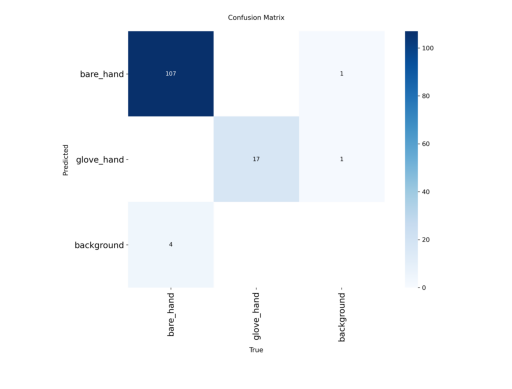

In [22]:
#confusion_matrix.png
#confusion_matrix_normalized.png

from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(
    "glove_detection/yolov8_glove_model/confusion_matrix.png"
)
plt.imshow(img)
plt.axis("off")



(np.float64(-0.5), np.float64(2249.5), np.float64(1499.5), np.float64(-0.5))

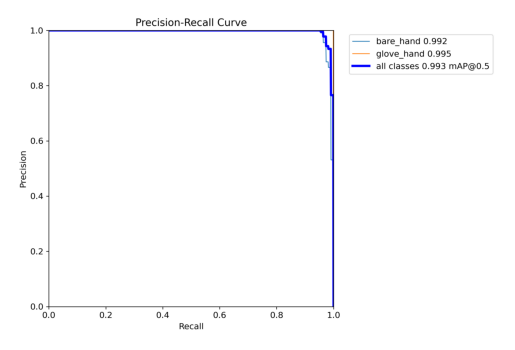

In [25]:
#Precision–Recall Curve

img = Image.open(
    "/content/glove_detection/yolov8_glove_model/BoxPR_curve.png"
)
plt.imshow(img)
plt.axis("off")


(np.float64(-0.5), np.float64(2249.5), np.float64(1499.5), np.float64(-0.5))

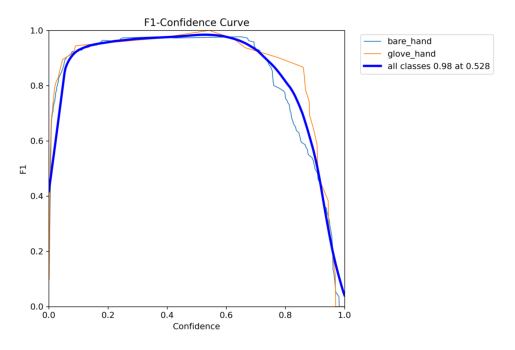

In [26]:
#F1, Precision, Recall Curves
img = Image.open(
    "/content/glove_detection/yolov8_glove_model/BoxF1_curve.png"
)
plt.imshow(img)
plt.axis("off")


In [30]:
!zip -r content.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.12.09/ (stored 0%)
  adding: content/.config/logs/2025.12.09/14.41.27.893750.log (deflated 86%)
  adding: content/.config/logs/2025.12.09/14.41.42.675750.log (deflated 57%)
  adding: content/.config/logs/2025.12.09/14.41.33.792924.log (deflated 58%)
  adding: content/.config/logs/2025.12.09/14.40.47.605300.log (deflated 92%)
  adding: content/.config/logs/2025.12.09/14.41.18.717681.log (deflated 58%)
  adding: content/.config/logs/2025.12.09/14.41.43.412452.log (deflated 56%)
  adding: content/.config/config_sentinel (stored 0%)
  ad